# 设计简单神经网络预测分布

### 介绍

给定数据集有五个字符的单词，希望通过神经网络学习到这些单词的对应的答对人数的分布。

### 导入相关库

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 定义网络

In [90]:
# Define the network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(5, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 7)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x = torch.sigmoid(self.fc1(x))
        x = F.relu(self.fc1(x))
        # x = torch.sigmoid(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x) # 将数据转换为概率分布
        return x

### 加载数据集

In [91]:
import pandas as pd
df = pd.read_excel("Problem_C_Data_Wordle_new.xlsx")
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,0.343806
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,0.491583
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,0.097901
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,0.187709
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,0.308737


In [92]:
# 构造输入输出数据
df_Word = df.loc[:, 'Word']
df_Word.head()

0    manly
1    molar
2    havoc
3    impel
4    condo
Name: Word, dtype: object

In [93]:
df_Distribution = df.iloc[:, 5:12]
df_Distribution.head()

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,0,2,17,37,29,12,2
1,0,4,21,38,26,9,1
2,0,2,16,38,30,12,2
3,0,3,21,40,25,9,1
4,0,2,17,35,29,14,3


In [94]:
# print shape of the data
print('shape of the df_Word is: ', df_Word.shape)
print('shape of the df_Distribution is: ', df_Distribution.shape)

shape of the df_Word is:  (359,)
shape of the df_Distribution is:  (359, 7)


### 转换数据格式

In [95]:
# 将数据转换为numpy数组
Word = df_Word.values # 1D array (359,)

In [96]:
def word2vec(word):
    # 将单词转换为向量
    # 这里由于单词长度为5，所以将单词转换为长度为5的向量是很简单的
    # 而在自然语言处理中，单词的长度是不固定的，所以需要将单词转换为固定长度的向量
    # 还要做embedding
    vec = np.zeros(5)
    for i in range(len(word)):
        vec[i] = ord(word[i]) - ord('a')
    return vec

def vec2word(vec):
    # 将向量转换为单词
    word = ''
    for i in range(len(vec)):
        word += chr(int(vec[i]) + ord('a'))
    return word

In [97]:
# 我们希望将Word转换为2D array ，又因为每个word的长度都一样所以不需要做padding，直接转换即可 (359,)-->(359,1)-->(359,5)
Word = np.array([word2vec(word) for word in Word])

In [98]:
print('shape of the Word is: ', Word.shape)
print('the preview of the Word is:\n', Word[:5])
print('the true Word is:\n', df_Word[:5])

shape of the Word is:  (359, 5)
the preview of the Word is:
 [[12.  0. 13. 11. 24.]
 [12. 14. 11.  0. 17.]
 [ 7.  0. 21. 14.  2.]
 [ 8. 12. 15.  4. 11.]
 [ 2. 14. 13.  3. 14.]]
the true Word is:
 0    manly
1    molar
2    havoc
3    impel
4    condo
Name: Word, dtype: object


In [99]:
# 对Word进行normalization
# 方法一
# mean = np.mean(Word, axis=0)
# std = np.std(Word, axis=0)
# Word = (Word - mean) / std
# 方法二
Word = Word / 26

In [100]:
Distribution = df_Distribution.values # 2D array (359,7)

In [101]:
# 将Distribution转换为float类型，并除于100
Distribution = Distribution.astype(np.float32)
Distribution = Distribution / 100
print('shape of the Distribution is: ', Distribution.shape)
print('the preview of the Distribution is:\n', Distribution[:5])

shape of the Distribution is:  (359, 7)
the preview of the Distribution is:
 [[0.   0.02 0.17 0.37 0.29 0.12 0.02]
 [0.   0.04 0.21 0.38 0.26 0.09 0.01]
 [0.   0.02 0.16 0.38 0.3  0.12 0.02]
 [0.   0.03 0.21 0.4  0.25 0.09 0.01]
 [0.   0.02 0.17 0.35 0.29 0.14 0.03]]


### 构造训练集和测试集

In [102]:
# 分割数据
train_size = int(0.7 * len(Word))
train_X = Word[:train_size]
train_Y = Distribution[:train_size]
test_X = Word[train_size:]
test_Y = Distribution[train_size:]

In [103]:
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).float()
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).float()

In [104]:
# 构造数据迭代器
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(test_X, test_Y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 网络参数

In [105]:
# 定义网络
model = SimpleNet()
# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [106]:
summary(model, input_size=(32,5))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet                                [32, 7]                   --
├─Linear: 1-1                            [32, 50]                  300
├─Linear: 1-2                            [32, 50]                  2,550
├─Linear: 1-3                            [32, 7]                   357
├─Softmax: 1-4                           [32, 7]                   --
Total params: 3,207
Trainable params: 3,207
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.04

### 训练网络

In [107]:
len(train_loader), len(test_loader)

(8, 4)

In [108]:
# 训练网络
num_epochs = 500
train_loss_list = []
test_loss_list = []
# optimizer = optim.SGD(model.parameters(), lr=1e-5)
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    # 训练网络
    model.train()
    for i, (word, distribution) in enumerate(train_loader):
        # 前向传播
        outputs = model(word)
        loss = criterion(outputs, distribution)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss / train_size)
    # 测试网络
    model.eval()
    with torch.no_grad():
        for i, (word,distribution) in enumerate(test_loader):
            outputs = model(word)
            loss = criterion(outputs, distribution)
            test_loss += loss.item()
    test_loss_list.append(test_loss/(359 - train_size))
    
    if (epoch + 1) % 20 == 0:
        print('Epoch [{:4d}/{:4d}], Train Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch + 1, num_epochs, train_loss_list[-1], test_loss_list[-1]))

Epoch [  20/ 500], Train Loss: 0.000094, Test Loss: 0.000099
Epoch [  40/ 500], Train Loss: 0.000090, Test Loss: 0.000096
Epoch [  60/ 500], Train Loss: 0.000086, Test Loss: 0.000091
Epoch [  80/ 500], Train Loss: 0.000084, Test Loss: 0.000088
Epoch [ 100/ 500], Train Loss: 0.000083, Test Loss: 0.000087
Epoch [ 120/ 500], Train Loss: 0.000080, Test Loss: 0.000087
Epoch [ 140/ 500], Train Loss: 0.000079, Test Loss: 0.000085
Epoch [ 160/ 500], Train Loss: 0.000076, Test Loss: 0.000088
Epoch [ 180/ 500], Train Loss: 0.000074, Test Loss: 0.000087
Epoch [ 200/ 500], Train Loss: 0.000071, Test Loss: 0.000087
Epoch [ 220/ 500], Train Loss: 0.000069, Test Loss: 0.000088
Epoch [ 240/ 500], Train Loss: 0.000068, Test Loss: 0.000087
Epoch [ 260/ 500], Train Loss: 0.000066, Test Loss: 0.000089
Epoch [ 280/ 500], Train Loss: 0.000065, Test Loss: 0.000088
Epoch [ 300/ 500], Train Loss: 0.000063, Test Loss: 0.000089
Epoch [ 320/ 500], Train Loss: 0.000061, Test Loss: 0.000090
Epoch [ 340/ 500], Train

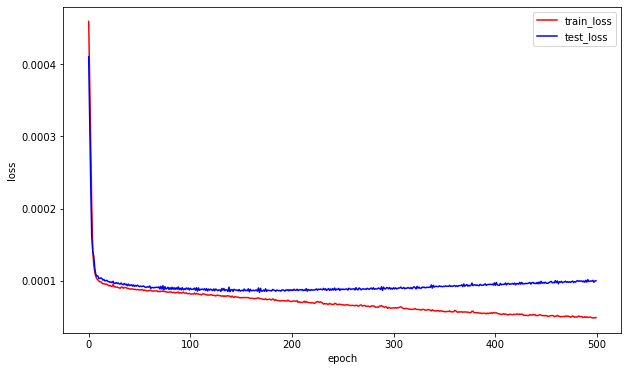

In [109]:
# 画图
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='train_loss', color='r')
plt.plot(test_loss_list, label='test_loss', color='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [110]:
min(test_loss_list)

8.408839413378801e-05

### 测试网络

### 加载模型

In [111]:
#  保存模型
torch.save(model.state_dict(), 'model_with5words,pth')

In [112]:
# 加载模型
model.load_state_dict(torch.load('model_with5words,pth'))

<All keys matched successfully>

In [113]:
# 预测
model.eval()

SimpleNet(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

In [114]:
idx = np.random.randint(0, len(test_X))
vec2word(test_X[idx])

'aaaaa'

In [115]:
print(train_size)

251


In [116]:
def mseloss(y_pred, y):
    return np.mean((y_pred - y)**2)

the distribution of the word focus is: tensor([[0.0012, 0.0614, 0.2130, 0.3423, 0.2612, 0.1146, 0.0062]])
the true distribution of the word focus is: tensor([0.0100, 0.0400, 0.2300, 0.3600, 0.2400, 0.1000, 0.0100])
criterion:  tensor(0.0003)
mseloss:  0.00025931958


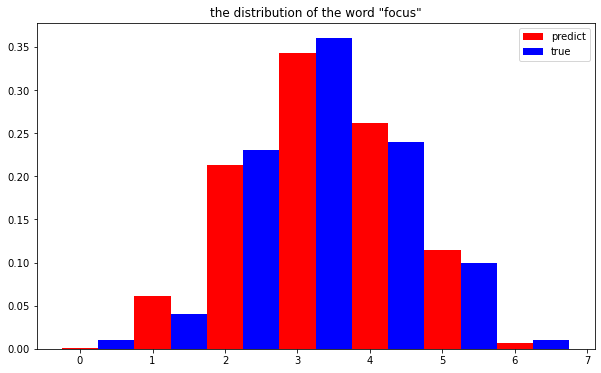

In [117]:
## 从测试集中随机抽取一个单词，预测其分布
with torch.no_grad():
    # 预测单个单词
    index = np.random.randint(0, len(test_X))
    # 还原单词
    vec = test_X[index] * 26
    word = vec2word(vec)
    vec = test_X[index]
    vec = vec.view(1, -1)
    output = model(vec)
    print('the distribution of the word {} is: {}'.format(word, output))
    print('the true distribution of the word {} is: {}'.format(word, test_Y[index]))
    print('criterion: ', criterion(output, test_Y[index].view(1, -1)))
    print('mseloss: ', mseloss(output.numpy(), test_Y[index].numpy()))
    # 画出预测的分布图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output[0].numpy(), width=0.5, color='r',  label='predict')
    plt.bar(np.arange(7) + 0.5, test_Y[index].numpy(), width=0.5, color='b', label='true')
    plt.title('the distribution of the word "{}"'.format(word))
    plt.legend()
    plt.show()

### 测试集总体的mse

In [118]:
# 求测试集总体的mse
with torch.no_grad():
    mse_sum = 0
    for idx in range(0, len(test_X)):
        output = model(test_X[idx].view(1, -1))
        mse_sum += mseloss(output.numpy(), test_Y[idx].numpy())
    print('mse_sum = ', mse_sum)

mse_sum =  0.3083657535389648


In [120]:
len(test_X)

108

### 预测单词eerie的分布

the distribution of the word eerie is: tensor([[4.2399e-34, 6.0240e-25, 7.0582e-20, 1.5703e-10, 2.0186e-04, 9.9976e-01,
         3.5037e-05]])


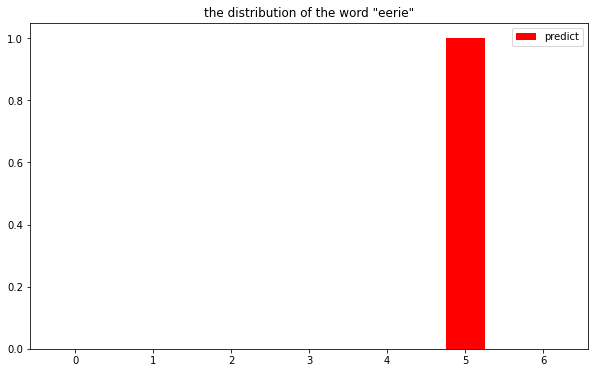

In [119]:
with torch.no_grad():
    # 预测单个单词
    word = 'eerie'
    vec = word2vec(word)
    vec = torch.from_numpy(vec).float()
    vec = vec.view(1, -1)
    output = model(vec)
    print('the distribution of the word {} is: {}'.format(word, output))
    # 画出预测的分布图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output[0].numpy(), width=0.5, color='r',  label='predict')
    plt.title('the distribution of the word "{}"'.format(word))
    plt.legend()
    plt.show()
